# 2. SHO Fitting in Pytorch

In [1]:
import sys
sys.path.append('../../')
sys.path.append('/home/ferroelectric/m3_learning/m3_learning/src')

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
# from m3_learning.be.nn import SHO_Model, SHO_NN_Model, SHO_fit_func_nn

# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

# import matplotlib.pyplot as plt
# import numpy as np

# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader

# from scipy.signal import resample
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
# from sklearn.metrics import mean_squared_error

# from m3_learning.optimizers.AdaHessian import AdaHessian
# from m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
# from m3_learning.be.processing import convert_amp_phase, SHO_fit_to_array
# from m3_learning.util.preprocessing import global_scaler
# from m3_learning.nn.random import random_seed
# from m3_learning.nn.benchmarks.inference import computeTime
from m3_learning.util.file_IO import make_folder
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
# from m3_learning.be.dataset import BE_Dataset
# from m3_learning.viz.style import set_style

# set_style("printing")

2023-04-26 10:03:37.122627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 10:03:37.238261: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-26 10:03:37.655382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-26 10:03:37.655431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [3]:
# import seaborn as sns
# # sns.set_theme(style="whitegrid")

# # Load the example tips dataset
# tips = sns.load_dataset("tips")

# # Draw a nested violinplot and split the violins for easier comparison
# sns.violinplot(data=tips, x="day", y="total_bill", hue="smoker",
#                split=True, inner="quart", linewidth=1,
#                palette={"Yes": "b", "No": ".85"})
# sns.despine(left=True)

# plt.show()


## Loads Data

In [4]:
# Specify the filename and the path to save the file
filename = 'data_raw.h5'
save_path = './../../../Data/2023_rapid_fitting'


data_path = save_path + '/' + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path, resample_bins = 80,  SHO_fit_func_NN = SHO_fit_func_nn)

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data_Reshaped
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
    ├ raw_data_resampled
├ Raw_Data-SHO_Fit_000
  --------------------
  ├ Fit
  ├ Guess
  ├ SHO_LSQF
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
  ├ comp

## Testing the Torch Function

The function for a simple-harmonic oscillator needs to be recast in PyTorch. Here we prove that the PyTorch function is implemented identically to the Numpy model. 

Note: This uses the results from the least squares fitting LSQF results. 

In [5]:
true = {'fitter' : 'NN',
        'resampled' : False, 
        "label": "NN Fit"}

predicted = {'fitter' : 'LSQF',
             'resampled' : False, 
             "label": "Raw", 
             'scaled': False}

BE_viz = Viz(dataset, printing, verbose=True)


True 


                  Resample = False
                  Raw Format = complex
                  fitter = NN
                  scaled = False
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = False
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  
predicted 


                  Resample = False
                  Raw Format = complex
                  fitter = LSQF
                  scaled = False
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = False
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  
./figures/Figure_7_PyTorch_fit_tester.png
./figures/Figure_7_PyTorch_fit_tester.svg


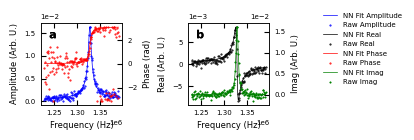

In [6]:
BE_viz.fit_tester(true, predicted, filename="Figure_7_PyTorch_fit_tester")

**Figure 7** Shows the result of the PyTorch function. The result based on the LSQF results shows that the PyTorch function is implemented correctly.

## Pytorch Model

### Model Architecture

### Scaling the Data

When training the neural network it is useful to scale the data. We apply a global scaler such that the spectrum have a mean of 0 and a standard deviation of 1.

#### Visualizing the Scaled Data


                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  
./figures/Figure_8_Scaled Raw Data.png
./figures/Figure_8_Scaled Raw Data.svg


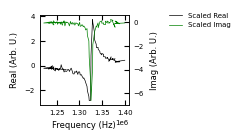

In [7]:
BE_viz = Viz(dataset, printing, verbose=True)


state = {'fitter' : 'LSQF',
             'resampled' : True,
             'scaled' : True,
             "label": "Scaled"}

BE_viz.nn_checker(state, filename="Figure_8_Scaled Raw Data")

**Figure 8** shows the scaled data. The data is scaled to have a mean of 0 and a standard deviation of 1. This is done using a global scaler of the entire spectrum. 


                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = None
                  
./figures/Figure_9_Phase_Shifted_Scaled_Histograms.png
./figures/Figure_9_Phase_Shifted_Scaled_Histograms.svg


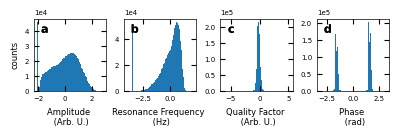

In [8]:
dataset.LSQF_phase_shift = np.pi/2

BE_viz.SHO_hist(dataset.SHO_fit_results(),
                      filename="Figure_9_Phase_Shifted_Scaled_Histograms")

**Figure 9** shows the histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is no transformation applied to the phase. This is used for computing the mean squared error or the neural network fit when validating the performance of the model. This is not used in the training of the model. The exception is that the scaling factor is applied to normalize the predictions to improve optimization. 

### Training the Model

We will train the model from scratch. Generally the model trains very well in a few epochs. This will take less than 5 minutes to train on a GPU.

In [17]:
random_seed(seed=42)

# instantiate the model
model = SHO_Model(dataset, training=True, model_basename='SHO_Fitter_original_data')

# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle = True)


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Using GPU NVIDIA GeForce RTX 3090


In [18]:
train = False

if train:
    # fits the model
    model.fit(dataset.X_train, 200)
else:
    model.load("./Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0415364887664543.pth")

### GPU Inference Speedtest

Here we show the speedtest for the GPU. This is done using the torch.cuda.synchronize() function. This is used to ensure that the GPU is done processing before the timer is stopped.

In [19]:
X_data, Y_data = dataset.NN_data()

model.inference_timer(X_data, batch_size=1000)

Mean execution time computed for 1383 batches of size 1000
Average execution time per batch (ms): 2.181606 ± 0.123295
Average execution time per iteration (ms): 0.002182 ± 0.000123
Total execution time (s): 3.02 


### Visualization of the Distribution of the NN Fit Results

It is useful to check the distribution of the scaled and unscaled fit results for the entire dataset, this will also allow us to add a correction for a phase shift (if necessary).


                  Resample = True
                  Raw Format = magnitude spectrum
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = 1.5707963267948966
                  
./figures/.png
./figures/.svg


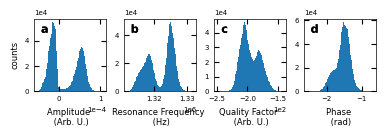

In [20]:
dataset.NN_phase_shift = np.pi/2

pred_data, scaled_param, parm = model.predict(X_data)

BE_viz.SHO_hist(parm)


                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = 1.5707963267948966
                  
./figures/.png
./figures/.svg


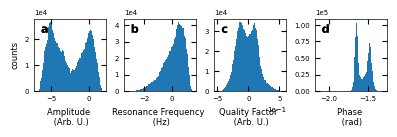

In [13]:
BE_viz.SHO_hist(scaled_param)

### Model Validation

It is helpful to view reconstructions of the data from the training and validation datasets. This ensures that the model is doing a good job of fitting the data.

./figures/Figure_9_NN_Validation_example_training.png
./figures/Figure_9_NN_Validation_example_training.svg


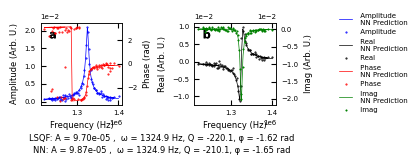

In [14]:
BE_viz.nn_validation(model, X_train, 
                     filename = "Figure_9_NN_Validation_example_training", 
                     SHO_results = y_train)

**Figure 10** A random reconstruction of the neural network fits for the training dataset

./figures/Figure_10_NN_Validation_example_test.png
./figures/Figure_10_NN_Validation_example_test.svg


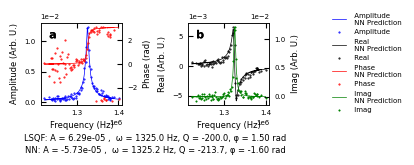

In [15]:
BE_viz.nn_validation(model, X_test, 
                     filename = "Figure_10_NN_Validation_example_test", 
                     SHO_results = y_test)

In [ ]:
pred_data, scaled_param, parm = model.predict(X_train[[0]])

### Validation Reconstruction

In [ ]:
nn_.predict(data_test, validation=True)

In [ ]:
i = np.random.randint(0, dataset.nn_validation.shape[0])

original = nn_.unscale_complex(data_test[[i],:])[0]
predicted = nn_.unscale_complex(dataset.nn_validation[[i], :])[0]

dataset.lsqf_viz.raw_data(original, predicted, predict_label='Neural Network')

In [ ]:
nn_.best_and_worst(data_test, dataset.nn_validation)
plt.show()

In [ ]:
dataset.nn_state_params


In [ ]:
dataset.nn_state_params = 'validation'
dataset.nn_scaled_state_params = True

In [ ]:
dataset.SHO_scaler.var_

In [ ]:
plt.hist(dataset.SHO_nn_phase.flatten(), bins=100)


In [ ]:
plt.hist(dataset.SHO_nn_phase.flatten(), bins=100)

In [ ]:
dataset.nn_scaled_state_params


In [ ]:
plt.hist(dataset.nn_validation_params_scaled[:,0].flatten(), bins=100)

In [ ]:
dataset.nn_state_params = 'validation'


In [ ]:
dataset._nn_state_params.reshape(-1, dataset.voltage_steps, 4)


In [ ]:
plt.hist(dataset.nn_validation_params[:,1].flatten(), bins=100)

In [ ]:
import pandas as pd

df = pd.DataFrame()

true = params_test
compare = dataset.nn_validation_params_scaled

names = [true, compare]
names_str = ['SHO', 'NN']
labels = ['Amplitude', 'Resonance', 'Q-Factor', 'Phase']

for j, name in enumerate(names):
    for i, label in enumerate(labels):
        dict_ = {"value": name[:,i],
                 "parameter": np.repeat(label, name.shape[0]),
                 "dataset": np.repeat(names_str[j], name.shape[0])}
        
        df = pd.concat((df, pd.DataFrame(dict_)))


In [ ]:
import seaborn as sns

df.head()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)

sns.violinplot(x='parameter', y='value', hue='dataset',
               data=df, ax=axs, scale='count', split=True, inner='quartile')

plt.show()